# Along-slope velocity

Calculate the velocity component tangent to the a bathymetry contour.

Load modules

In [5]:
from pathlib import Path
from dask.distributed import Client
import numpy as np
import xarray as xr
import dask


import xgcm
import cf_xarray
import intake

# For plotting
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import cmocean as cm
import pyproj


By default retain metadata after operations. This can retain out of date metadata, so some caution is required

In [6]:
xr.set_options(keep_attrs=True)

Start a cluster with multiple cores

In [7]:
client = Client(threads_per_worker = 1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 7,Total memory: 32.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37559,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 7
Started: Just now,Total memory: 32.00 GiB
Comm: tcp://127.0.0.1:37987,Total threads: 1
Dashboard: /proxy/41535/status,Memory: 4.57 GiB
Nanny: tcp://127.0.0.1:42423,


### Load Data

Load the ACCESS-NRI Intake Catalog & get the datastore for our experiment.

In [8]:
catalog = intake.cat.access_nri
experiment = '01deg_jra55v13_ryf9091'

# We call our datastore esm_ds
esm_ds = catalog[experiment]
esm_ds

,unique
filename,3469
file_id,33
path,11947
filename_timestamp,3372
frequency,5
start_date,3361
end_date,3360
variable,205
variable_long_name,197
variable_standard_name,36


Limit to Southern Ocean and single RYF year by setting our search parameters

In [9]:
lat_slice  = slice(-80, -59)

start_time = '2086-01-01'
end_time   = '2086-12-31'

# Since we are only interested in 2086, we can use a wildcard to specify our start date:
# See https://access-nri-intake-catalog.readthedocs.io/en/latest/usage/quickstart.html#data-discovery for more info
dates_2086 = '2086.*'
variable_name = 'hu'

Load bathymetry data. Discard the geolon and geolat coordinates: these are 2D curvilinear coordinates that are only required when working above 65N

In [10]:
hu_ds = esm_ds.search(variable=variable_name,start_date=dates_2086).to_dask()

# Now we select our latitude slice
hu_ds = hu_ds.sel(yu_ocean=lat_slice).drop_vars(['geolat_c','geolon_c'])

hu = hu_ds['hu']
hu_ds

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.02/lib/python3.11/site-packages/intake_esm/source.py:280: ConcatenationWarning: Attempting to concatenate datasets without valid dimension coordinates: retaining only first dataset. Request valid dimension coordinate to silence this warning.
  warnings.warn(


<xarray.Dataset> Size: 7MB
Dimensions:   (yu_ocean: 484, xu_ocean: 3600)
Coordinates:
  * xu_ocean  (xu_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.8 79.9 80.0
  * yu_ocean  (yu_ocean) float64 4kB -79.99 -79.95 -79.9 ... -59.06 -59.01
Data variables:
    hu        (yu_ocean, xu_ocean) float32 7MB dask.array<chunksize=(484, 900), meta=np.ndarray>
Attributes: (12/19)
    filename:                                 ocean_grid.nc
    title:                                    ACCESS-OM2-01
    grid_type:                                mosaic
    grid_tile:                                1
    intake_esm_vars:                          ['hu']
    intake_esm_attrs:filename:                ocean_grid.nc
    ...                                       ...
    intake_esm_attrs:variable_standard_name:  ,,,,,,,,,sea_floor_depth_below_...
    intake_esm_attrs:variable_cell_methods:   ,,,,,time: point,time: point,ti...
    intake_esm_attrs:variable_units:          degrees_E,degrees_N,days since ...
    intake_esm_attrs:realm:                   ocean
    intake_esm_attrs:_data_format_:           netcdf
    intake_esm_dataset_key:                   ocean_grid.fx

Now we want to load velocity data, limit to upper 500m and take the mean in time

In [11]:
depth_slice = slice(0,500) # Save our depth slice

esm_ds.search(variable=['u','v'])

,unique
filename,29
file_id,7
path,2070
filename_timestamp,12
frequency,4
start_date,1404
end_date,1404
variable,49
variable_long_name,43
variable_standard_name,11


We have a few frequencies - so lets have a look at what they are, and use that to limit ourselves to a single dataset

In [12]:
esm_ds.search(variable=['u','v']).df.frequency.unique()

array(['3mon', '1mon', '1day', '3hr'], dtype=object)

In [13]:
# Try only the 1 month frequency data:
esm_ds.search(variable=['u','v'],frequency='1mon')

,unique
filename,1
file_id,1
path,920
filename_timestamp,0
frequency,1
start_date,920
end_date,920
variable,46
variable_long_name,42
variable_standard_name,11


Perfect! That gives us a single dataset, so let's load it, limit ourselves to the top 500m like we wanted, and take the mean in time.

In [14]:
# Load the dataset

"""
A note about chunking: 
  - Selecting *good* chunks can speed up loading out datasets substantially. 
    Unfortunately, selecting *bad* chunks can also slow things down a lot. Generally, 
    unless you are sure how you want to chunk things, settings "chunks":"auto" is 
    often the way to go: 
    
"""

ds = esm_ds.search(
    variable=['u','v'],frequency='1mon',start_date=dates_2086
).to_dask(
    xarray_open_kwargs = {
        "decode_timedelta" : False, # Needed to silence unimportant warnings at present - awaiting release of upstream fix 
        "chunks": "auto",
    }
) 

# Select the slice we wanted
ds.sel(yu_ocean = lat_slice).sel(st_ocean=depth_slice)

# Take the mean over time
uv_ds = ds.mean(dim='time')

uv_ds

<xarray.Dataset> Size: 6GB
Dimensions:   (st_ocean: 75, yu_ocean: 2700, xu_ocean: 3600)
Coordinates:
  * st_ocean  (st_ocean) float64 600B 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * xu_ocean  (xu_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.8 79.9 80.0
  * yu_ocean  (yu_ocean) float64 22kB -81.09 -81.05 -81.0 ... 89.92 89.96 90.0
Data variables:
    u         (st_ocean, yu_ocean, xu_ocean) float32 3GB dask.array<chunksize=(14, 600, 800), meta=np.ndarray>
    v         (st_ocean, yu_ocean, xu_ocean) float32 3GB dask.array<chunksize=(14, 600, 800), meta=np.ndarray>
Attributes: (12/16)
    filename:                                 ocean.nc
    title:                                    ACCESS-OM2-01
    grid_type:                                mosaic
    grid_tile:                                1
    intake_esm_vars:                          ['u', 'v']
    intake_esm_attrs:filename:                ocean.nc
    ...                                       ...
    intake_esm_attrs:variable_standard_name:  ,,,,,,,,,,,,,,,,,,sea_water_con...
    intake_esm_attrs:variable_cell_methods:   ,,,,,,,,,,,,,,,,,,time: mean,ti...
    intake_esm_attrs:variable_units:          degrees_E,degrees_N,meters,mete...
    intake_esm_attrs:realm:                   ocean
    intake_esm_attrs:_data_format_:           netcdf
    intake_esm_dataset_key:                   ocean.1mon

## Load model grid information  - we can search the Access-NRI Intake Catalog for this as of `access-nri-intake` version 1.1.1:
Note you must be using the conda/analysis3-25.02 or later environment: 
see also https://github.com/ACCESS-NRI/intake-training/blob/main/2025_02/building-intake-esm-datastore-slides-202502.pdf

In [15]:
# There are ocean grid variables for each year of output - so to save looking at them all, we can just specify the year
# Note: even though we only need one file, xarray still needs to open them all to check the metadata - this can take a while

# This just checks that we are using the right catalog version:
import access_nri_intake
import packaging.version
if packaging.version.Version(access_nri_intake.__version__) < packaging.version.Version('1.1.1'):
    raise AssertionError("You must be using `access-nri-intake 1.1.1` or greater. Please see info above")

grid = esm_ds.search(file_id='ocean_grid',start_date=dates_2086).to_dask()

# Again, we don't need the geolon variables
grid = grid.drop_vars(['geolon_t', 'geolat_t', 'geolon_c', 'geolat_c'])
grid

<xarray.Dataset> Size: 2GB
Dimensions:     (time: 4, yt_ocean: 2700, xt_ocean: 3600, yu_ocean: 2700,
                 xu_ocean: 3600)
Coordinates:
  * xt_ocean    (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.85 79.95
  * yt_ocean    (yt_ocean) float64 22kB -81.11 -81.07 -81.02 ... 89.94 89.98
  * time        (time) object 32B 2086-01-01 00:00:00 ... 2086-10-01 00:00:00
  * xu_ocean    (xu_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.8 79.9 80.0
  * yu_ocean    (yu_ocean) float64 22kB -81.09 -81.05 -81.0 ... 89.92 89.96 90.0
Data variables:
    ht          (time, yt_ocean, xt_ocean) float32 156MB dask.array<chunksize=(1, 675, 900), meta=np.ndarray>
    hu          (time, yu_ocean, xu_ocean) float32 156MB dask.array<chunksize=(1, 675, 900), meta=np.ndarray>
    dxt         (time, yt_ocean, xt_ocean) float32 156MB dask.array<chunksize=(1, 675, 900), meta=np.ndarray>
    dyt         (time, yt_ocean, xt_ocean) float32 156MB dask.array<chunksize=(1, 675, 900), meta=np.ndarray>
    dxu         (time, yu_ocean, xu_ocean) float32 156MB dask.array<chunksize=(1, 675, 900), meta=np.ndarray>
    dyu         (time, yu_ocean, xu_ocean) float32 156MB dask.array<chunksize=(1, 675, 900), meta=np.ndarray>
    area_t      (time, yt_ocean, xt_ocean) float32 156MB dask.array<chunksize=(1, 675, 900), meta=np.ndarray>
    area_u      (time, yu_ocean, xu_ocean) float32 156MB dask.array<chunksize=(1, 675, 900), meta=np.ndarray>
    kmt         (time, yt_ocean, xt_ocean) float32 156MB dask.array<chunksize=(1, 675, 900), meta=np.ndarray>
    kmu         (time, yu_ocean, xu_ocean) float32 156MB dask.array<chunksize=(1, 675, 900), meta=np.ndarray>
    drag_coeff  (time, yu_ocean, xu_ocean) float32 156MB dask.array<chunksize=(1, 675, 900), meta=np.ndarray>
Attributes: (12/16)
    filename:                                 ocean_grid.nc
    title:                                    ACCESS-OM2-01
    grid_type:                                mosaic
    grid_tile:                                1
    intake_esm_vars:                          ['xt_ocean', 'yt_ocean', 'time'...
    intake_esm_attrs:filename:                ocean_grid.nc
    ...                                       ...
    intake_esm_attrs:variable_standard_name:  ,,,,,,,,,sea_floor_depth_below_...
    intake_esm_attrs:variable_cell_methods:   ,,,,,time: point,time: point,ti...
    intake_esm_attrs:variable_units:          degrees_E,degrees_N,days since ...
    intake_esm_attrs:realm:                   ocean
    intake_esm_attrs:_data_format_:           netcdf
    intake_esm_dataset_key:                   ocean_grid.fx

### Along-slope velocity

We calculate the along-slope velocity component by projecting the velocity field to the tangent vector, $u_{along} = \boldsymbol{u \cdot \hat{t}}$, and the cross-slope component by projecting to the normal vector, $v_{cross} = \boldsymbol{u \cdot \hat{n}}$. The schematic below defines the unit normal normal and tangent vectors for a given bathymetric contour, $\boldsymbol{n}$ and $\boldsymbol{t}$ respectively. 

![Sketch of topographic gradient](images/topographic_gradient_sketch.png)

Accordingly, the code below calculates the along-slope velocity component as

$$ u_{along} = (u,v) \boldsymbol{\cdot} \left(\frac{h_y}{|\nabla h|} , -\frac{h_x}{|\nabla h|}\right) = 
u \frac{h_y}{|\nabla h|} - v \frac{h_x}{|\nabla h|}, $$  

and similarly the cross-slope velocity component as

$$ v_{cross} = (u,v) \boldsymbol{\cdot} \left(\frac{h_x}{|\nabla h|} , \frac{h_y}{|\nabla h|}\right)  = 
u \frac{h_x}{|\nabla h|} + v \frac{h_y}{|\nabla h|}.$$ 


We need the derivatives of the bathymetry which we compute using the `xgcm` functionality.

In [16]:
# Give information on the grid: location of u (momentum) and t (tracer) points on B-grid 

# We need to merge the two datasets. They're on the same coordinates, so this should be straightforward.
ds = xr.merge([hu_ds, grid])
ds.coords['xt_ocean'].attrs.update(axis='X')
ds.coords['xu_ocean'].attrs.update(axis='X', c_grid_axis_shift=0.5)
ds.coords['yt_ocean'].attrs.update(axis='Y')
ds.coords['yu_ocean'].attrs.update(axis='Y', c_grid_axis_shift=0.5)

grid = xgcm.Grid(ds, periodic=['X'])

# Take topographic gradient (simple gradient over one grid cell) and move back to u-grid
dhu_dx = grid.interp( grid.diff(ds.hu, 'X') / grid.interp(ds.dxu, 'X'), 'X')

# In meridional direction, we need to specify what happens at the boundary
dhu_dy = grid.interp( grid.diff(ds.hu, 'Y', boundary='extend') / grid.interp(ds.dyt, 'X'), 'Y', boundary='extend')

# Select latitude slice
dhu_dx = dhu_dx.sel(yu_ocean=lat_slice)
dhu_dy = dhu_dy.sel(yu_ocean=lat_slice)

# Magnitude of the topographic slope (to normalise the topographic gradient)
topographic_slope_magnitude = np.sqrt(dhu_dx**2 + dhu_dy**2)

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.02/lib/python3.11/site-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 185.51 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.02/lib/python3.11/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.02/lib/python3.11/site-packages/xgcm/grid_ufunc.py:832: FutureW

Calculate along-slope velocity component

In [17]:
# Get the u and v data arrays out of our dataset
u, v = uv_ds['u'],uv_ds['v']

# Along-slope velocity
alongslope_velocity = u * dhu_dy / topographic_slope_magnitude - v * dhu_dx / topographic_slope_magnitude

alongslope_velocity = alongslope_velocity.mean(dim='time') # Remember to average over time again - otheriwse we wind up with an extraneous extra dim in the plot
alongslope_velocity

<xarray.DataArray (st_ocean: 75, yu_ocean: 484, xu_ocean: 3600)> Size: 523MB
dask.array<mean_agg-aggregate, shape=(75, 484, 3600), dtype=float32, chunksize=(14, 484, 800), chunktype=numpy.ndarray>
Coordinates:
  * st_ocean  (st_ocean) float64 600B 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * xu_ocean  (xu_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.8 79.9 80.0
  * yu_ocean  (yu_ocean) float64 4kB -79.99 -79.95 -79.9 ... -59.06 -59.01
Attributes:
    long_name:      i-current
    units:          m/sec
    valid_range:    [-10.  10.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_water_x_velocity

### Vertical averaging (we only need this to plot the velocity on a map)

In [18]:
# Import edges of st_ocean and add lat/lon dimensions:
st_edges_ocean = esm_ds.search(variable='st_edges_ocean',start_date=dates_2086).to_dask()
st_edges_array = st_edges_ocean.expand_dims({'yu_ocean': u.yu_ocean, 'xu_ocean': u.xu_ocean}, axis=[1, 2])
st_edges_array = st_edges_array.sel(yu_ocean = lat_slice)['st_edges_ocean']

st_ocean = esm_ds.search(variable='st_ocean',start_date=dates_2086,file_id='ocean')
st_ocean = st_ocean.to_dask(
    xarray_open_kwargs = {
        "decode_timedelta" : False, # Needed to silence unimportant warnings at present - awaiting release of upstream fix 
        "chunks": "auto",
    }
)['st_ocean']

hu = hu_ds['hu']
hu

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.02/lib/python3.11/site-packages/intake_esm/source.py:82: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  ds = xr.open_dataset(url, **xarray_open_kwargs)
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.02/lib/python3.11/site-packages/intake_esm/source.py:82: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  ds = xr.open_dataset(url, **xarray_open_kwargs)
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.02/lib/python3.11/site-packages/intake_esm/source.py:82: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTi

<xarray.DataArray 'hu' (yu_ocean: 484, xu_ocean: 3600)> Size: 7MB
dask.array<getitem, shape=(484, 3600), dtype=float32, chunksize=(484, 900), chunktype=numpy.ndarray>
Coordinates:
  * xu_ocean  (xu_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.8 79.9 80.0
  * yu_ocean  (yu_ocean) float64 4kB -79.99 -79.95 -79.9 ... -59.06 -59.01
Attributes:
    long_name:     ocean depth on u-cells
    units:         m
    valid_range:   [-1.e+09  1.e+09]
    cell_methods:  time: point

In [19]:
# Adjust edges at bottom for partial thickness:
st_edges_with_partial = st_edges_array.where(st_edges_array<hu, other=hu)
thickness = st_edges_with_partial.diff(dim='st_edges_ocean')

# Change coordinate of thickness to st_ocean (needed for multipling with other variables):
st_ocean_datastore = esm_ds.search(variable='st_ocean',start_date=dates_2086,file_id='ocean')
st_ocean = st_ocean_datastore.to_dask(
    xarray_open_kwargs = {
        "decode_timedelta" : False, # Needed to silence unimportant warnings at present - awaiting release of upstream fix 
        "chunks": "auto",
    }
)['st_ocean']

thickness['st_edges_ocean'] = st_ocean.values
thickness = thickness.rename(({'st_edges_ocean': 'st_ocean'}))
thickness = thickness.sel(st_ocean=slice(0, 500))

# Depth average gives us the barotropic velocity
barotropic_alongslope_velocity = (alongslope_velocity * thickness).sum('st_ocean') / thickness.sum('st_ocean')
barotropic_alongslope_velocity

<xarray.DataArray (yu_ocean: 484, xu_ocean: 3600)> Size: 14MB
dask.array<truediv, shape=(484, 3600), dtype=float64, chunksize=(484, 800), chunktype=numpy.ndarray>
Coordinates:
  * xu_ocean  (xu_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.8 79.9 80.0
  * yu_ocean  (yu_ocean) float64 4kB -79.99 -79.95 -79.9 ... -59.06 -59.01
Attributes:
    long_name:      i-current
    units:          m/sec
    valid_range:    [-10.  10.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_water_x_velocity

### Plotting

Create a circular path to clip plots

In [20]:
theta  = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.45
verts  = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

Create a land mask for plotting, set land cells to 1 and rest to NaN

In [21]:
land = xr.where(np.isnan(hu.rename('land')), 1, np.nan)

### Map of along-slope velocity with bathymetry contours. 
**On a Large ARE Instance, this should take ~45 seconds**

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.02/lib/python3.11/site-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 46.91 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.02/lib/python3.11/site-packages/dask/_task_spec.py:741: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.02/lib/python3.11/site-packages/dask/_task_spec.py:741: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.02/lib/python3.11/site-packages/dask/_task_spec.py:741: RuntimeWarning: invalid value encountered in divide
 

Took approximately 0:00:46.924747s to run


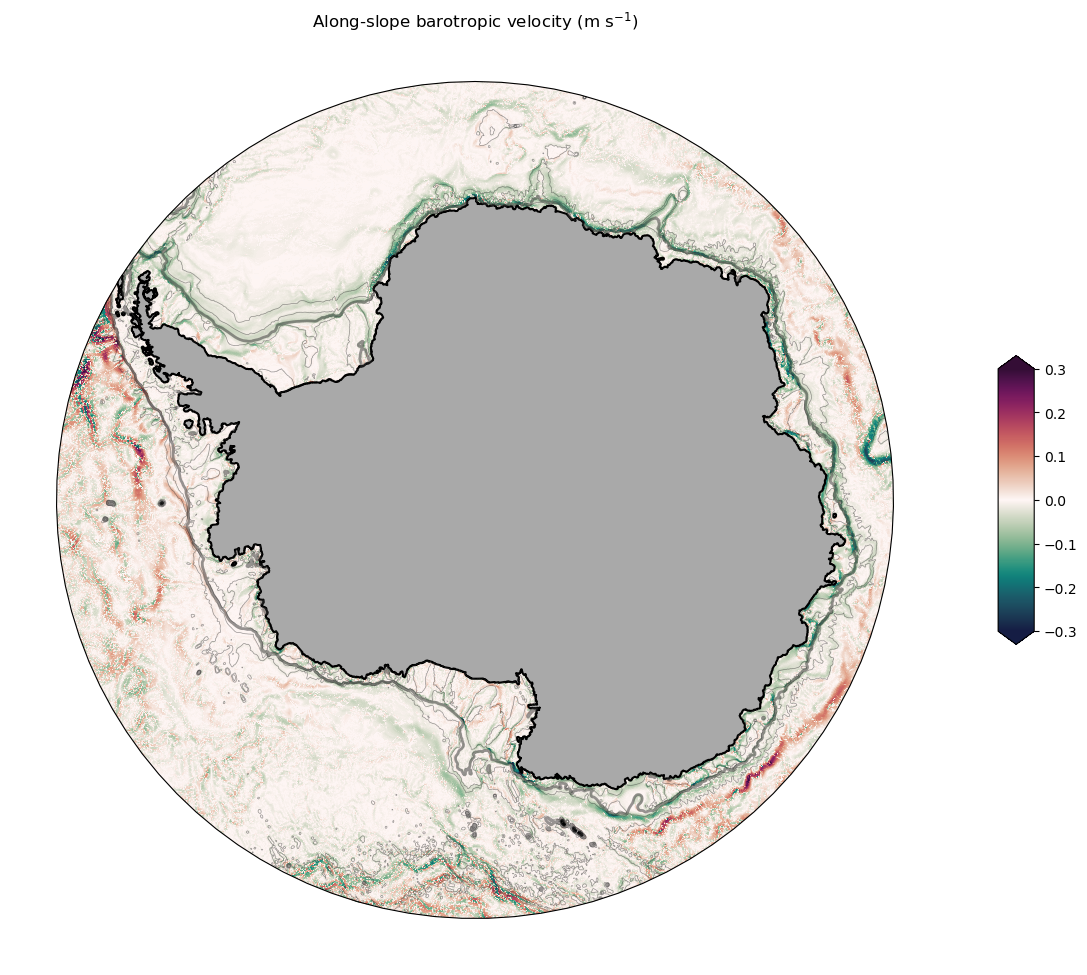

In [22]:
fig = plt.figure(1, figsize=(15, 15))

ax = plt.subplot(1, 1, 1, projection=ccrs.SouthPolarStereo(), facecolor="darkgrey")
ax.set_boundary(circle, transform=ax.transAxes)
    
# Filled land 
land.plot.contourf(ax=ax, colors='darkgrey',
                   zorder=2,
                   transform=ccrs.PlateCarree(),
                   add_colorbar=False)

# Coastline
land.fillna(0).plot.contour(ax=ax, colors='k', levels=[0, 1],
                            transform=ccrs.PlateCarree(),
                            add_colorbar=False)

# Depth contours
hu.plot.contour(ax=ax, levels=[500, 1000, 2000, 3000],
                colors='0.2', linewidths=[0.5, 2, 0.5, 0.5], alpha=0.5,
                transform=ccrs.PlateCarree())

# Along slope barotropic velocity
sc = barotropic_alongslope_velocity.plot.pcolormesh(ax=ax, cmap=cm.cm.curl,
                                         transform=ccrs.PlateCarree(),
                                         vmin=-0.3, vmax=0.3,
                                         cbar_kwargs={'orientation': 'vertical',
                                                      'shrink': 0.25,
                                                      'extend': 'both',
                                                      'label': None,
                                                      'aspect': 8})
  
ax.set_title('Along-slope barotropic velocity (m s$^{-1}$)');

In [23]:
client.close()